In [1]:
# import required libraries
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils_ import *

# 1. Finding a_ref using the flooding rule

![image.png](./figures/fig_flooding.png)

In [2]:
def find_a_ref(model, input_, y_ref=0, method='flood', step_width=0.005, max_it=10e4, normalize_top=False):
    
    """
    find_a_ref : function to find the reference offset 'a_ref' for a given model, input and reference value 'y_ref'

    Parameters:
    model (torch.nn.Sequential): PyTorch model to be used for the computation
    input_ (torch.Tensor): Input sample for which we search the offset 'a_ref'
    y_ref (float, optional): Reference value for the output y (default: 0)
    method (str, optional): Method used to find the reference value for the output a (default: 'flood')
    step_width (float, optional): Step width used in the 'flood' method (default: 0.005)
    max_it (int, optional): Maximum number of iterations before stopping the loop and displaying a warning message. (default: 10e4)
    normalize_top (bool, optional): If True, the model top layers are rescaled to +1/-1 as weights in the last layer. While this is not
                                    described in the paper, we found that it is closer to our intuition of the flooding rule. (default: False)  
    
    Returns:
    torch.Tensor : Found reference offset 'a_ref'

    """
    print(f'y = {np.round(model.forward(input_).detach().numpy(),2)} / y_ref = {y_ref}')
    
    if normalize_top==True:
        model = rescale_top(model)
    
    if method=='flood': # other methods for finding a_ref can be added
        
        y_t_ = model.forward(input_)
        a_ref_ = model[:-1](input_)
        
        update = (torch.ones(a_ref_.shape[1]))*step_width
        counter = 0
        
        if y_t_>y_ref:
            
            while y_t_>y_ref:     

                a_ref_ = torch.max(torch.zeros(a_ref_.shape[1]),(a_ref_-update))

                y_t_ = model[-1:].forward(a_ref_)
                counter +=1 
                print(f'iteration {counter} - y_t: {y_t_}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break
                
        else:
            
            while y_t_<y_ref:     

                a_ref_ = torch.max(torch.zeros(a_ref_.shape[1]),(a_ref_+update))

                y_t_ = model[-1:].forward(a_ref_)
                counter +=1 
                print(f'iteration {counter} - y_t: {y_t_}', end='\r')
                if counter > max_it:
                    print(f'! reference value {y_ref} was not reached within {round(max_it)} iterations!')
                    break

    return a_ref_

### limitations/ edge cases of the flooding rule:

-  if the model[-1].bias > y_ref, then y_ref never will be reached.
-  a large stepwith can result in poor a_refs.
-  top_layer normalization (rescale-top) was not introduced in [1] but we found that it can be helpful to generate more faithful explanations.
-  the flooding rule does not ensure that the offset found lays within the distribution of activations, especially when y_ref>>y.
-  an asymetric treatment of activations based on their respective weights in the last layer can be reasonable (for example in section VI. A).

# 2. Restructuring with a given a_ref

![image.png](./figures/fig_restructuring.png)

In [3]:
def restructure_model(model, a_ref, in_layer=-3, out_layer=-1):
    
    """
    Restructures the incoming and outgoing layers of a PyTorch model according to [1].
    
    Parameters:
        model (torch.nn.Sequential): Model to be restructured. Assumption for top layer structure [Linear(i,j), ReLU, Linear(j,1)]
        a_ref (torch.Tensor): Reference offset used for restructuring. Assumption a_ref.shape = (1, j)
        in_layer (int): The index of the incoming layer to be restructured. Default is -3.
        out_layer (int): The index of the outgoing layer to be restructured. Default is -1.
        
    Returns:
        nn.Module: A restructured version of the input model.
    """
    
    # get weights and biases
    W_in = model[in_layer].weight
    W_out = model[out_layer].weight
    bias_in = model[in_layer].bias.view(1,-1)

    # manipulate biases in incoming layer
    # a_ref multiplied by -1, 0, and 1 before being added to biases
    # biases multiplied with incoming weight manipulation (1, -1, -1)
    bias_in = torch.cat((bias_in-a_ref, -bias_in, -bias_in+a_ref),1)

    # initialization of new top layer structure
    top_in = nn.Linear(W_in.shape[1], W_in.shape[0]*3)
    top_act = nn.ReLU()
    top_out = nn.Linear(W_out.shape[1]*3, W_out.shape[0])

    with torch.no_grad():
        top_in.weight = nn.Parameter(torch.cat((W_in, -W_in, -W_in),0))  #incoming weights multiplied by 1, -1, and -1
        top_in.bias = nn.Parameter(bias_in)
        top_out.weight = nn.Parameter(torch.cat((W_out, W_out, -W_out),1)) #outgoing weights multiplied by 1, 1, and -1
        top_out.bias = nn.Parameter(torch.zeros([1,1]))

    if out_layer<-1:
        model_top_left = list(model[out_layer:])
    else:
        model_top_left = []
    
    new_model = nn.Sequential(*(list(model[:in_layer]) + [top_in, top_act, top_out] + model_top_left))
    
    return new_model

# 3. Small demo

y = [[1.64]] / y_ref = 1
a i_sample:     tensor([[1.0568, 4.5529, 2.4636]], grad_fn=<ReluBackward0>)
a_ref i_sample: tensor([[0.1468, 3.6428, 1.5536]], grad_fn=<MaximumBackward0>)
y_ with a_ref:  tensor([[1.0000]], grad_fn=<AddmmBackward0>)


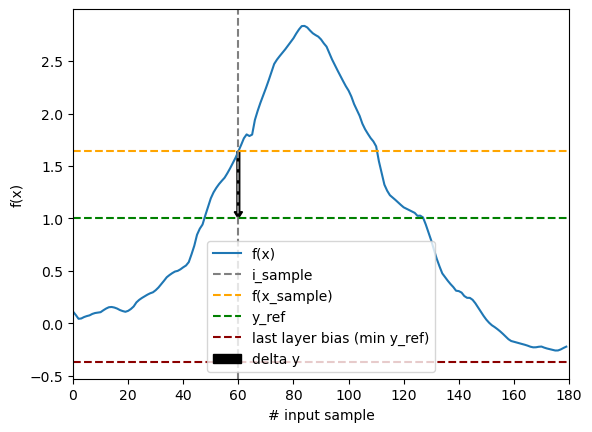

In [4]:
# find a_ref

model = copy.deepcopy(torch.load('./demo/dummy_model'))
input_ = torch.load('./demo/dummy_input')

i_sample = 60
y_ref = 1

input_sample = input_[i_sample].reshape(1,-1)
output_sample = model(input_sample).detach().numpy()[0][0]

plot_setting(model, input_, i_sample, output_sample, y_ref)

a_ref = find_a_ref(model, input_sample, y_ref)

print(f'a i_sample:     {model[:-1](input_sample)}')
print(f'a_ref i_sample: {a_ref}')

print(f'y_ with a_ref:  {model[-1:](a_ref)}')

In [5]:
# restructure model

model_restructured = restructure_model(model, a_ref, in_layer=-3, out_layer=-1)

print(model(input_sample))
print(model_restructured(input_sample))

tensor([[1.6387]], grad_fn=<AddmmBackward0>)
tensor([[0.6387]], grad_fn=<AddmmBackward0>)


##### The output of the model is reduced by y_ref for sample i. Therefore, explaining the model_restructured for input_sample using the respective LRP rules yields a contextualized explanation relative to y_ref.

Reference: 

[1] S. Letzgus, P. Wagner, J. Lederer, W. Samek, K.-R. M ̈uller, and G. Montavon. Toward explainable artificial intelligence for regression models: A methodological perspective. IEEE Signal Processing Magazine, 39(4):40–58, 2022.